In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import os
import glob as gb
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout
from zipfile import ZipFile
import matplotlib.image as mpimg
import warnings

sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
ZipFile("F:/dogs_vs_cats/dataset/train.zip","r").extractall("F:/dogs_vs_cats/dataset/")
ZipFile("F:/dogs_vs_cats/dataset/test1.zip", "r").extractall("F:/dogs_vs_cats/dataset/")

In [4]:
train_path = "F:/dogs_vs_cats/dataset/train"
test_path = "F:/dogs_vs_cats/dataset/test1"

In [5]:
filenames = os.listdir(train_path)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(category)
    else:
        categories.append(category)

df = pd.DataFrame({
    'Image': filenames,
    'Category': categories})
df.head(-5)

,Image,Category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat
...,...,...
24990,dog.9990.jpg,dog
24991,dog.9991.jpg,dog
24992,dog.9992.jpg,dog
24993,dog.9993.jpg,dog


<AxesSubplot:>

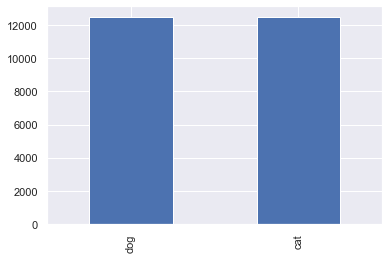

In [19]:
df['Category'].value_counts().plot.bar()

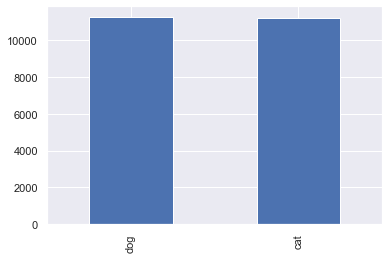

<AxesSubplot:>

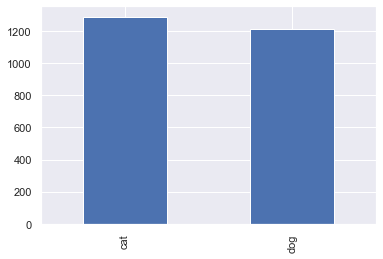

In [20]:
df_train, df_validation = train_test_split(df, test_size=0.1, random_state=18)
df_train = df_train.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_train['Category'].value_counts().plot.bar()
plt.show()
df_validation['Category'].value_counts().plot.bar()

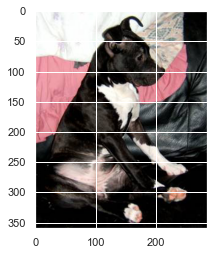

In [21]:
sample = random.choice(df['Image'])
plt.imshow(plt.imread(("F:/dogs_vs_cats/train/"+sample)))

In [7]:
size  = 150
channels = 3
batch = 128
epochs = 15

datagen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.2,
                             width_shift_range=.2, height_shift_range=.2,
                             rotation_range=30,
                             brightness_range=[0.8, 1.2],
                             horizontal_flip=True)

datagenValidation = ImageDataGenerator(rescale=1./255)

In [24]:
X_train = datagen.flow_from_dataframe(
    df_train, 
    directory = train_path, 
    x_col = 'Image',
    y_col = 'Category',
    target_size= (size,size),
    class_mode = 'binary',
    shuffle = True,
    batch_size = batch)

X_validation = datagenValidation.flow_from_dataframe(
    df_validation, 
    directory = train_path, 
    x_col = 'Image',
    y_col = 'Category',
    target_size= (size,size),
    class_mode = 'binary',
    shuffle = True,
    batch_size = batch)

Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


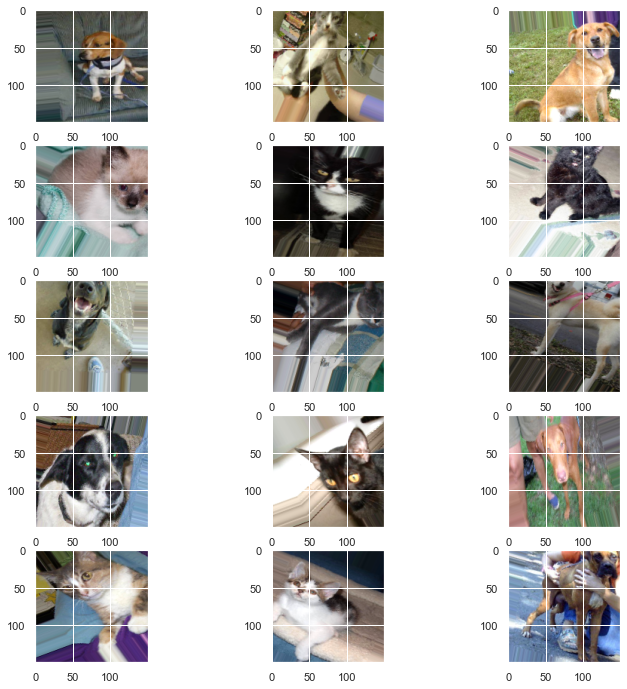

In [41]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in X_train:
        image = X_batch[0]
        plt.imshow(image)
        break
# plt.tight_layout()
plt.show()

In [42]:
checkpoint_filepath = 'best_model.hdf5'
callback_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callback_learningrate = ReduceLROnPlateau(monitor='val_accuracy', mode='max', min_delta=0.03, patience=3, factor=.5, min_lr=0.00001, verbose=1)
callbacks = [callback_checkpoint, callback_learningrate]

In [43]:
Model = Sequential([Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(size,size,channels)),
                    BatchNormalization(),
                    MaxPool2D(2,2),
                    Dropout(0.2),
                 
                    Conv2D(filters=64,  kernel_size=(5,5), activation="relu"),
                    BatchNormalization(),
                    MaxPool2D(3,3),
                    Dropout(0.2),
                
                    Conv2D(filters=128, kernel_size=(7,7), activation="relu"),
                    BatchNormalization(),
                    MaxPool2D(4,4),
                    Dropout(0.2),
                 
                    Flatten(),
                    
                    Dense(units=4096, activation="relu"),                 
                    BatchNormalization(),
                    Dropout(0.4),
                    
                    Dense(units=1024, activation="relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    
                                        
                    Dense(units=2, activation="relu"),
                    BatchNormalization(),
                    Dropout(0.5),
                    
                    Dense(units=1, activation="sigmoid"),
])


Model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])

Model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 70, 70, 64)        51264     
_________________________________________________________________
batch_normalization_13 (Batc (None, 70, 70, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 64)       

In [44]:
history = Model.fit(X_train, validation_data=X_validation, epochs=epochs, callbacks=callbacks) 

Epoch 1/15
176/176 [==============================] - 672s 4s/step - loss: 0.7232 - accuracy: 0.5695 - val_loss: 1.5696 - val_accuracy: 0.5152
Epoch 2/15
176/176 [==============================] - 652s 4s/step - loss: 0.6659 - accuracy: 0.6066 - val_loss: 0.7494 - val_accuracy: 0.5544
Epoch 3/15
176/176 [==============================] - 660s 4s/step - loss: 0.6144 - accuracy: 0.6555 - val_loss: 0.8160 - val_accuracy: 0.5708
Epoch 4/15
176/176 [==============================] - 673s 4s/step - loss: 0.5809 - accuracy: 0.6849 - val_loss: 0.6933 - val_accuracy: 0.6128
Epoch 5/15
176/176 [==============================] - 671s 4s/step - loss: 0.5553 - accuracy: 0.7012 - val_loss: 0.5168 - val_accuracy: 0.7744
Epoch 6/15
176/176 [==============================] - 649s 4s/step - loss: 0.5305 - accuracy: 0.7156 - val_loss: 0.4325 - val_accuracy: 0.8072
Epoch 7/15
176/176 [==============================] - 645s 4s/step - loss: 0.5179 - accuracy: 0.7264 - val_loss: 0.4506 - val_accuracy: 0.7776

In [3]:
Model = tf.keras.models.load_model('best_model.hdf5')

In [11]:
filenames = os.listdir(test_path)
df_test = pd.DataFrame({'Image':filenames})

df_test.head(-5)

ValueError: If using all scalar values, you must pass an index

In [8]:
X_test = datagenValidation.flow_from_dataframe(
    df_test, 
    directory=test_path, 
    x_col='Image',
    y_col=None,
    class_mode=None,
    target_size= (size,size),
    batch_size=batch,
    shuffle=False
)

AttributeError: 'str' object has no attribute 'copy'

In [27]:
X_train.class_indices

{'cat': 0, 'dog': 1}

In [28]:
y_pred = Model.predict(X_test)

In [29]:
y_pred = np.where(y_pred > .5, "Dog", "Cat")
y_pred

array([['Dog'],
       ['Cat'],
       ['Cat'],
       ...,
       ['Dog'],
       ['Cat'],
       ['Cat']], dtype='<U3')

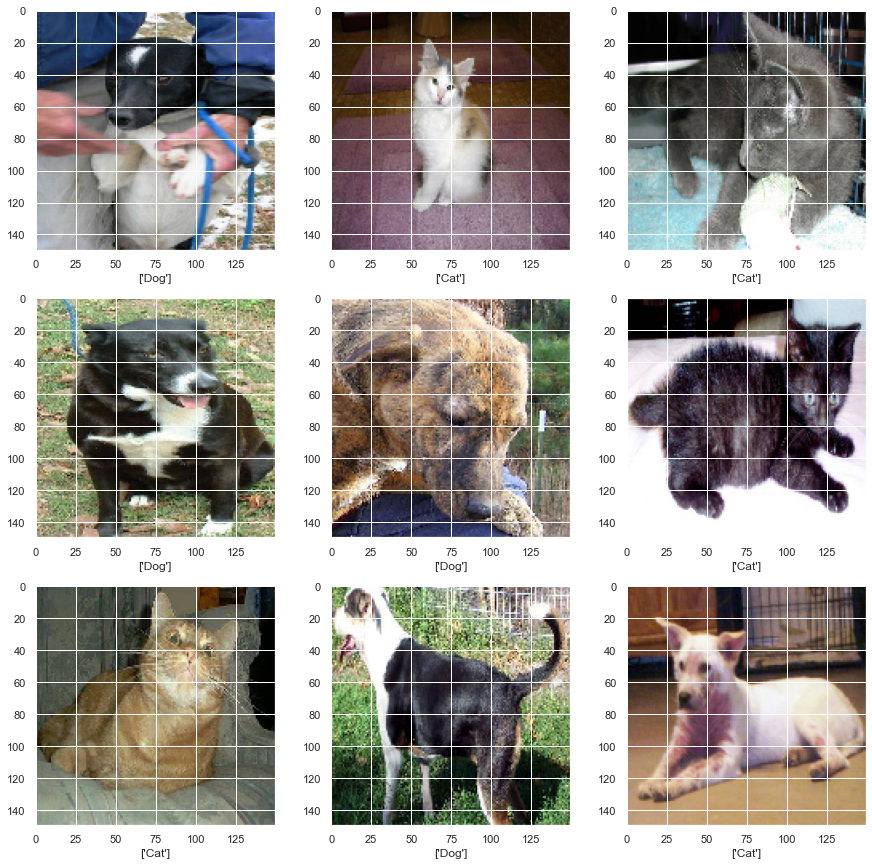

In [51]:
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[0][i])
    plt.xlabel(y_pred[i])
    
plt.show()

In [30]:
label = np.where(y_pred=="Cat", 0, 1)
label

array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [31]:
df_submission = pd.read_csv('F:/dogs_vs_cats/sampleSubmission.csv')
df_submission['label'] = label
df_submission.head(-5)

,id,label
0,1,1
1,2,0
2,3,0
3,4,1
4,5,1
...,...,...
12490,12491,0
12491,12492,1
12492,12493,1
12493,12494,0


In [32]:
df_submission.to_csv('F:/dogs_vs_cats/sampleSubmission1.csv', index=False)

In [25]:
submission = pd.read_csv('F:/dogs_vs_cats/sampleSubmission1.csv')
submission.head(-5)

,id,label
0,1,1
1,2,0
2,3,0
3,4,1
4,5,1
...,...,...
12490,12491,0
12491,12492,1
12492,12493,1
12493,12494,0
